In [ ]:
# ! unzip -oq /home/aistudio/data/data85135/常规赛：PALM病理性近视病灶检测与分割.zip
# ! rm -rf __MACOSX
# ! mv 常规赛：PALM病理性近视病灶检测与分割 dataset

In [ ]:
# ! git clone https://gitee.com/paddlepaddle/PaddleSeg.git
! pip -q install patta

import sys

sys.path.append('PaddleSeg')

In [ ]:
import os
import random

def create_list():
    file_path = 'dataset/Train/fundus_image'
    imgs_name = os.listdir(file_path)
    random.shuffle(imgs_name)
    with open('dataset/Train/train.txt', 'w') as tf:
        with open('dataset/Train/val.txt', 'w') as ef:
            for idx, img_name in enumerate(imgs_name):
                img_path = os.path.join('fundus_image', img_name)
                lab_1_path = img_exist('dataset/Train', img_path.replace('fundus_image', 'Lesion_Masks/Detachment').replace('jpg', 'bmp'))
                lab_2_path = img_exist('dataset/Train', img_path.replace('fundus_image', 'Lesion_Masks/Atrophy').replace('jpg', 'bmp'))
                if (idx % 10 + 1) < 9:
                    tf.write(img_path + ' ' + lab_1_path + ' ' + lab_2_path + '\n')
                else:
                    ef.write(img_path + ' ' + lab_1_path + ' ' + lab_2_path + '\n')

def img_exist(path, name):
    p = os.path.join(path, name)
    if os.path.exists(p):
        return name
    else:
        return 'None'

# create_list()

In [ ]:
from paddleseg.datasets import DBDataset
import paddleseg.transforms as T

# 构建训练集
train_transforms = [
    T.Resize(target_size=(1120, 1120)),  # 修改大小
    T.Normalize()  # 归一化
]
train_dataset = DBDataset(
    transforms=train_transforms,
    dataset_root='dataset/Train',
    num_classes=2,
    mode='train',
    train_path='dataset/Train/train.txt',
    separator=' ',
)

# 构建验证集
val_transforms = [
    T.Resize(target_size=(1120, 1120)),
    T.Normalize()
]
val_dataset = DBDataset(
    transforms=val_transforms,
    dataset_root='dataset/Train',
    num_classes=2,
    mode='val',
    val_path='dataset/Train/val.txt',
    separator=' ',
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1120, 1120) 1 1 (1120, 1120) (1120, 1120)


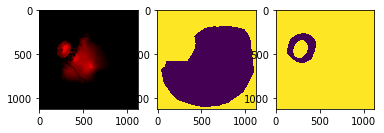

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

for img, clas_1, clas_2, lab_1, lab_2 in train_dataset:
    if np.min(lab_1) == 0 and np.min(lab_2) == 0:
        print(img.shape, clas_1, clas_2, lab_1.shape, lab_2.shape)
        plt.subplot(131);plt.imshow(img.transpose((1, 2, 0)))
        plt.subplot(132);plt.imshow(lab_1)
        plt.subplot(133);plt.imshow(lab_2)
        plt.show()
        break

In [11]:
import paddle
from paddleseg.models import DBAttentionUNet
from paddleseg.models.losses import BCELoss, DiceLoss, MixedLoss
from paddle.nn import CrossEntropyLoss

# 模型
url = 'save_output/last_model/model.pdparams'
model = DBAttentionUNet(num_classes=2, pretrained=url)
# 测试
# a = paddle.randn(shape=[1, 3, 1120, 1120])
# c = model(a)
# print(c)
# 训练参数
epochs = 10
batch_size = 2
iters = epochs * len(train_dataset) // batch_size
# 损失函数
mix_losses = [BCELoss('dynamic', 'dynamic'), DiceLoss()]
mix_coef = [1, 1]
mixloss = MixedLoss(mix_losses, mix_coef)
losses = {}
losses['types'] = [CrossEntropyLoss(), CrossEntropyLoss(), mixloss, mixloss]
losses['coef'] = [0, 0, 1, 1]
# 学习率及优化器
base_lr = 3e-4
# lr = paddle.optimizer.lr.CosineAnnealingDecay(base_lr, T_max=(iters // 5))
lr = paddle.optimizer.lr.PolynomialDecay(base_lr, 4277, end_lr=3e-8)
optimizer = paddle.optimizer.Adam(lr, parameters=model.parameters(), weight_decay=paddle.regularizer.L2Decay(1e-9))

2021-05-22 12:18:43 [INFO]	Loading pretrained model from save_output/last_model/model.pdparams
2021-05-22 12:18:44 [INFO]	There are 356/356 variables loaded into DBAttentionUNet.


In [12]:
from paddleseg.core import train

train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    save_dir='save_output',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/10),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:238: UserWarning: The dtype of left and right variables are not the same, left dtype is VarType.FP32, but right

2021-05-22 12:18:57 [INFO]	[TRAIN] epoch=1, iter=10/3200, loss=0.9555, lr=0.000299, batch_cost=1.1094, reader_cost=0.06593, ips=1.8027 samples/sec | ETA 00:58:59
2021-05-22 12:19:08 [INFO]	[TRAIN] epoch=1, iter=20/3200, loss=0.8839, lr=0.000299, batch_cost=1.0351, reader_cost=0.00021, ips=1.9321 samples/sec | ETA 00:54:51
2021-05-22 12:19:18 [INFO]	[TRAIN] epoch=1, iter=30/3200, loss=0.9945, lr=0.000298, batch_cost=1.0359, reader_cost=0.00029, ips=1.9308 samples/sec | ETA 00:54:43
2021-05-22 12:19:28 [INFO]	[TRAIN] epoch=1, iter=40/3200, loss=0.9221, lr=0.000297, batch_cost=1.0367, reader_cost=0.00025, ips=1.9292 samples/sec | ETA 00:54:36
2021-05-22 12:19:39 [INFO]	[TRAIN] epoch=1, iter=50/3200, loss=0.8302, lr=0.000297, batch_cost=1.0375, reader_cost=0.00029, ips=1.9277 samples/sec | ETA 00:54:28
2021-05-22 12:19:49 [INFO]	[TRAIN] epoch=1, iter=60/3200, loss=0.9371, lr=0.000296, batch_cost=1.0380, reader_cost=0.00022, ips=1.9267 samples/sec | ETA 00:54:19
2021-05-22 12:20:00 [INFO]	[

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:238: UserWarning: The dtype of left and right variables are not the same, left dtype is VarType.INT32, but right dtype is VarType.BOOL, the right dtype will convert to VarType.INT32
  format(lhs_dtype, rhs_dtype, lhs_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:238: UserWarning: The dtype of left and right variables are not the same, left dtype is VarType.INT64, but right dtype is VarType.BOOL, the right dtype will convert to VarType.INT64
  format(lhs_dtype, rhs_dtype, lhs_dtype))
160/160 [==============================] - 52s 322ms/step - batch_cost: 0.1603 - reader cost: 0.1405


2021-05-22 12:25:12 [INFO]	[EVAL] #Images=160 mIoU=0.4941 Acc=0.9881 Kappa=0.0000 
2021-05-22 12:25:12 [INFO]	[EVAL] Class IoU: 
[0.     0.9881]
2021-05-22 12:25:12 [INFO]	[EVAL] Class Acc: 
[0.     0.9881]
2021-05-22 12:25:12 [INFO]	[EVAL] #Images=160 mIoU=0.6922 Acc=0.9518 Kappa=0.5821 
2021-05-22 12:25:12 [INFO]	[EVAL] Class IoU: 
[0.4344 0.95  ]
2021-05-22 12:25:12 [INFO]	[EVAL] Class Acc: 
[0.8396 0.957 ]
2021-05-22 12:25:16 [INFO]	[EVAL] The model with the best validation mIoU (0.6922) was saved at iter 320.
2021-05-22 12:25:27 [INFO]	[TRAIN] epoch=2, iter=330/3200, loss=0.8551, lr=0.000277, batch_cost=1.1219, reader_cost=0.07269, ips=1.7827 samples/sec | ETA 00:53:39
2021-05-22 12:25:38 [INFO]	[TRAIN] epoch=2, iter=340/3200, loss=0.8675, lr=0.000276, batch_cost=1.0416, reader_cost=0.00019, ips=1.9201 samples/sec | ETA 00:49:38
2021-05-22 12:25:48 [INFO]	[TRAIN] epoch=2, iter=350/3200, loss=1.0384, lr=0.000276, batch_cost=1.0421, reader_cost=0.00020, ips=1.9192 samples/sec | ETA 

160/160 [==============================] - 53s 328ms/step - batch_cost: 0.1634 - reader cost: 0.1425


2021-05-22 12:31:44 [INFO]	[EVAL] #Images=160 mIoU=0.4941 Acc=0.9881 Kappa=0.0000 
2021-05-22 12:31:44 [INFO]	[EVAL] Class IoU: 
[0.     0.9881]
2021-05-22 12:31:44 [INFO]	[EVAL] Class Acc: 
[0.     0.9881]
2021-05-22 12:31:44 [INFO]	[EVAL] #Images=160 mIoU=0.7265 Acc=0.9561 Kappa=0.6432 
2021-05-22 12:31:44 [INFO]	[EVAL] Class IoU: 
[0.499 0.954]
2021-05-22 12:31:44 [INFO]	[EVAL] Class Acc: 
[0.8201 0.9637]
2021-05-22 12:31:48 [INFO]	[EVAL] The model with the best validation mIoU (0.7265) was saved at iter 640.
2021-05-22 12:31:59 [INFO]	[TRAIN] epoch=3, iter=650/3200, loss=0.9351, lr=0.000254, batch_cost=1.1236, reader_cost=0.07751, ips=1.7801 samples/sec | ETA 00:47:45
2021-05-22 12:32:10 [INFO]	[TRAIN] epoch=3, iter=660/3200, loss=0.9763, lr=0.000254, batch_cost=1.0415, reader_cost=0.00024, ips=1.9204 samples/sec | ETA 00:44:05
2021-05-22 12:32:20 [INFO]	[TRAIN] epoch=3, iter=670/3200, loss=0.9567, lr=0.000253, batch_cost=1.0419, reader_cost=0.00020, ips=1.9195 samples/sec | ETA 00

160/160 [==============================] - 52s 328ms/step - batch_cost: 0.1630 - reader cost: 0.1422


2021-05-22 12:38:16 [INFO]	[EVAL] #Images=160 mIoU=0.4941 Acc=0.9881 Kappa=0.0000 
2021-05-22 12:38:16 [INFO]	[EVAL] Class IoU: 
[0.     0.9881]
2021-05-22 12:38:16 [INFO]	[EVAL] Class Acc: 
[0.     0.9881]
2021-05-22 12:38:16 [INFO]	[EVAL] #Images=160 mIoU=0.6904 Acc=0.9531 Kappa=0.5788 
2021-05-22 12:38:16 [INFO]	[EVAL] Class IoU: 
[0.4294 0.9514]
2021-05-22 12:38:16 [INFO]	[EVAL] Class Acc: 
[0.8978 0.9554]
2021-05-22 12:38:19 [INFO]	[EVAL] The model with the best validation mIoU (0.7265) was saved at iter 640.
2021-05-22 12:38:30 [INFO]	[TRAIN] epoch=4, iter=970/3200, loss=0.8444, lr=0.000232, batch_cost=1.1018, reader_cost=0.05732, ips=1.8152 samples/sec | ETA 00:40:57
2021-05-22 12:38:40 [INFO]	[TRAIN] epoch=4, iter=980/3200, loss=0.8692, lr=0.000231, batch_cost=1.0404, reader_cost=0.00023, ips=1.9224 samples/sec | ETA 00:38:29
2021-05-22 12:38:51 [INFO]	[TRAIN] epoch=4, iter=990/3200, loss=0.8122, lr=0.000231, batch_cost=1.0412, reader_cost=0.00017, ips=1.9209 samples/sec | ETA 

160/160 [==============================] - 53s 332ms/step - batch_cost: 0.1650 - reader cost: 0.1444


2021-05-22 12:44:47 [INFO]	[EVAL] #Images=160 mIoU=0.4941 Acc=0.9881 Kappa=0.0000 
2021-05-22 12:44:47 [INFO]	[EVAL] Class IoU: 
[0.     0.9881]
2021-05-22 12:44:47 [INFO]	[EVAL] Class Acc: 
[0.     0.9881]
2021-05-22 12:44:47 [INFO]	[EVAL] #Images=160 mIoU=0.7166 Acc=0.9558 Kappa=0.6260 
2021-05-22 12:44:47 [INFO]	[EVAL] Class IoU: 
[0.4794 0.9539]
2021-05-22 12:44:47 [INFO]	[EVAL] Class Acc: 
[0.8563 0.9607]
2021-05-22 12:44:50 [INFO]	[EVAL] The model with the best validation mIoU (0.7265) was saved at iter 640.
2021-05-22 12:45:01 [INFO]	[TRAIN] epoch=5, iter=1290/3200, loss=1.0175, lr=0.000210, batch_cost=1.0957, reader_cost=0.04828, ips=1.8253 samples/sec | ETA 00:34:52
2021-05-22 12:45:11 [INFO]	[TRAIN] epoch=5, iter=1300/3200, loss=1.1640, lr=0.000209, batch_cost=1.0421, reader_cost=0.00020, ips=1.9192 samples/sec | ETA 00:33:00
2021-05-22 12:45:22 [INFO]	[TRAIN] epoch=5, iter=1310/3200, loss=1.0037, lr=0.000208, batch_cost=1.0419, reader_cost=0.00021, ips=1.9195 samples/sec | E

160/160 [==============================] - 52s 322ms/step - batch_cost: 0.1603 - reader cost: 0.1401


2021-05-22 12:51:16 [INFO]	[EVAL] #Images=160 mIoU=0.4941 Acc=0.9881 Kappa=0.0000 
2021-05-22 12:51:16 [INFO]	[EVAL] Class IoU: 
[0.     0.9881]
2021-05-22 12:51:16 [INFO]	[EVAL] Class Acc: 
[0.     0.9881]
2021-05-22 12:51:16 [INFO]	[EVAL] #Images=160 mIoU=0.7058 Acc=0.9541 Kappa=0.6068 
2021-05-22 12:51:16 [INFO]	[EVAL] Class IoU: 
[0.4593 0.9522]
2021-05-22 12:51:16 [INFO]	[EVAL] Class Acc: 
[0.8522 0.959 ]
2021-05-22 12:51:19 [INFO]	[EVAL] The model with the best validation mIoU (0.7265) was saved at iter 640.
2021-05-22 12:51:30 [INFO]	[TRAIN] epoch=6, iter=1610/3200, loss=0.8056, lr=0.000187, batch_cost=1.1094, reader_cost=0.06452, ips=1.8027 samples/sec | ETA 00:29:24
2021-05-22 12:51:41 [INFO]	[TRAIN] epoch=6, iter=1620/3200, loss=0.9162, lr=0.000186, batch_cost=1.0410, reader_cost=0.00017, ips=1.9213 samples/sec | ETA 00:27:24
2021-05-22 12:51:51 [INFO]	[TRAIN] epoch=6, iter=1630/3200, loss=0.9273, lr=0.000186, batch_cost=1.0426, reader_cost=0.00019, ips=1.9182 samples/sec | E

160/160 [==============================] - 52s 322ms/step - batch_cost: 0.1603 - reader cost: 0.1404


2021-05-22 12:57:46 [INFO]	[EVAL] #Images=160 mIoU=0.4941 Acc=0.9881 Kappa=0.0000 
2021-05-22 12:57:46 [INFO]	[EVAL] Class IoU: 
[0.     0.9881]
2021-05-22 12:57:46 [INFO]	[EVAL] Class Acc: 
[0.     0.9881]
2021-05-22 12:57:46 [INFO]	[EVAL] #Images=160 mIoU=0.7466 Acc=0.9579 Kappa=0.6769 
2021-05-22 12:57:46 [INFO]	[EVAL] Class IoU: 
[0.5375 0.9557]
2021-05-22 12:57:46 [INFO]	[EVAL] Class Acc: 
[0.7901 0.9689]
2021-05-22 12:57:50 [INFO]	[EVAL] The model with the best validation mIoU (0.7466) was saved at iter 1920.
2021-05-22 12:58:01 [INFO]	[TRAIN] epoch=7, iter=1930/3200, loss=0.7443, lr=0.000165, batch_cost=1.1089, reader_cost=0.06379, ips=1.8035 samples/sec | ETA 00:23:28
2021-05-22 12:58:12 [INFO]	[TRAIN] epoch=7, iter=1940/3200, loss=0.7952, lr=0.000164, batch_cost=1.0411, reader_cost=0.00025, ips=1.9210 samples/sec | ETA 00:21:51
2021-05-22 12:58:22 [INFO]	[TRAIN] epoch=7, iter=1950/3200, loss=1.1699, lr=0.000163, batch_cost=1.0527, reader_cost=0.00020, ips=1.8998 samples/sec | 

160/160 [==============================] - 52s 322ms/step - batch_cost: 0.1603 - reader cost: 0.1401


2021-05-22 13:04:17 [INFO]	[EVAL] #Images=160 mIoU=0.4941 Acc=0.9881 Kappa=0.0000 
2021-05-22 13:04:17 [INFO]	[EVAL] Class IoU: 
[0.     0.9881]
2021-05-22 13:04:17 [INFO]	[EVAL] Class Acc: 
[0.     0.9881]
2021-05-22 13:04:17 [INFO]	[EVAL] #Images=160 mIoU=0.7073 Acc=0.9546 Kappa=0.6095 
2021-05-22 13:04:17 [INFO]	[EVAL] Class IoU: 
[0.4619 0.9528]
2021-05-22 13:04:17 [INFO]	[EVAL] Class Acc: 
[0.8618 0.959 ]
2021-05-22 13:04:20 [INFO]	[EVAL] The model with the best validation mIoU (0.7466) was saved at iter 1920.
2021-05-22 13:04:31 [INFO]	[TRAIN] epoch=8, iter=2250/3200, loss=1.0006, lr=0.000142, batch_cost=1.1000, reader_cost=0.05490, ips=1.8182 samples/sec | ETA 00:17:24
2021-05-22 13:04:41 [INFO]	[TRAIN] epoch=8, iter=2260/3200, loss=0.9213, lr=0.000142, batch_cost=1.0419, reader_cost=0.00018, ips=1.9195 samples/sec | ETA 00:16:19
2021-05-22 13:04:52 [INFO]	[TRAIN] epoch=8, iter=2270/3200, loss=0.7834, lr=0.000141, batch_cost=1.0418, reader_cost=0.00023, ips=1.9198 samples/sec | 

160/160 [==============================] - 51s 322ms/step - batch_cost: 0.1602 - reader cost: 0.1402


2021-05-22 13:10:46 [INFO]	[EVAL] #Images=160 mIoU=0.4941 Acc=0.9881 Kappa=0.0000 
2021-05-22 13:10:46 [INFO]	[EVAL] Class IoU: 
[0.     0.9881]
2021-05-22 13:10:46 [INFO]	[EVAL] Class Acc: 
[0.     0.9881]
2021-05-22 13:10:46 [INFO]	[EVAL] #Images=160 mIoU=0.6860 Acc=0.9528 Kappa=0.5707 
2021-05-22 13:10:46 [INFO]	[EVAL] Class IoU: 
[0.4209 0.9512]
2021-05-22 13:10:46 [INFO]	[EVAL] Class Acc: 
[0.9111 0.9545]
2021-05-22 13:10:49 [INFO]	[EVAL] The model with the best validation mIoU (0.7466) was saved at iter 1920.
2021-05-22 13:11:00 [INFO]	[TRAIN] epoch=9, iter=2570/3200, loss=0.8654, lr=0.000120, batch_cost=1.1041, reader_cost=0.06131, ips=1.8115 samples/sec | ETA 00:11:35
2021-05-22 13:11:11 [INFO]	[TRAIN] epoch=9, iter=2580/3200, loss=0.9962, lr=0.000119, batch_cost=1.0412, reader_cost=0.00027, ips=1.9209 samples/sec | ETA 00:10:45
2021-05-22 13:11:21 [INFO]	[TRAIN] epoch=9, iter=2590/3200, loss=0.8123, lr=0.000118, batch_cost=1.0413, reader_cost=0.00028, ips=1.9208 samples/sec | 

160/160 [==============================] - 51s 321ms/step - batch_cost: 0.1597 - reader cost: 0.1395


2021-05-22 13:17:15 [INFO]	[EVAL] #Images=160 mIoU=0.4941 Acc=0.9881 Kappa=0.0000 
2021-05-22 13:17:15 [INFO]	[EVAL] Class IoU: 
[0.     0.9881]
2021-05-22 13:17:15 [INFO]	[EVAL] Class Acc: 
[0.     0.9881]
2021-05-22 13:17:15 [INFO]	[EVAL] #Images=160 mIoU=0.7337 Acc=0.9589 Kappa=0.6550 
2021-05-22 13:17:15 [INFO]	[EVAL] Class IoU: 
[0.5103 0.957 ]
2021-05-22 13:17:15 [INFO]	[EVAL] Class Acc: 
[0.8799 0.9629]
2021-05-22 13:17:19 [INFO]	[EVAL] The model with the best validation mIoU (0.7466) was saved at iter 1920.
2021-05-22 13:17:30 [INFO]	[TRAIN] epoch=10, iter=2890/3200, loss=0.7126, lr=0.000097, batch_cost=1.1139, reader_cost=0.07020, ips=1.7955 samples/sec | ETA 00:05:45
2021-05-22 13:17:40 [INFO]	[TRAIN] epoch=10, iter=2900/3200, loss=1.1823, lr=0.000097, batch_cost=1.0512, reader_cost=0.00024, ips=1.9025 samples/sec | ETA 00:05:15
2021-05-22 13:17:51 [INFO]	[TRAIN] epoch=10, iter=2910/3200, loss=0.7078, lr=0.000096, batch_cost=1.0416, reader_cost=0.00021, ips=1.9202 samples/sec

160/160 [==============================] - 51s 321ms/step - batch_cost: 0.1597 - reader cost: 0.1398


2021-05-22 13:23:45 [INFO]	[EVAL] #Images=160 mIoU=0.4941 Acc=0.9881 Kappa=0.0000 
2021-05-22 13:23:45 [INFO]	[EVAL] Class IoU: 
[0.     0.9881]
2021-05-22 13:23:45 [INFO]	[EVAL] Class Acc: 
[0.     0.9881]
2021-05-22 13:23:45 [INFO]	[EVAL] #Images=160 mIoU=0.7285 Acc=0.9579 Kappa=0.6464 
2021-05-22 13:23:45 [INFO]	[EVAL] Class IoU: 
[0.501  0.9561]
2021-05-22 13:23:45 [INFO]	[EVAL] Class Acc: 
[0.8718 0.9623]
2021-05-22 13:23:48 [INFO]	[EVAL] The model with the best validation mIoU (0.7466) was saved at iter 1920.
<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
Customize Function has been applied to <class 'paddle.nn.layer.norm.SyncBatchNorm'>
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
Cannot find suitable count function for <class 'paddle.nn.layer.common.Upsample'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.norm.BatchNorm2D'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flop

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:143: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:238: UserWarning: The dtype of left and right variables are not the same, left dtype is VarType.FP32, but right dtype is VarType.INT32, the right dtype will convert to VarType.FP32
  format(lhs_dtype, rhs_dtype, lhs_dtype))


Total Flops: 557239631872     Total Params: 22782896


In [13]:
import paddle
from paddleseg.models import DBAttentionUNet
import paddleseg.transforms as T
from paddleseg.core import infer
import os
import cv2
from tqdm import tqdm
from PIL import Image
import numpy as np
import patta as tta

def nn_infer(model, imgs_path, is_tta=True):
    if not os.path.exists('Lesion_Segmentation'):
        os.mkdir('Lesion_Segmentation')
    if not os.path.exists('Lesion_Segmentation/Atrophy'):
        os.mkdir('Lesion_Segmentation/Atrophy')
    if not os.path.exists('Lesion_Segmentation/Detachment'):
        os.mkdir('Lesion_Segmentation/Detachment')
    # 预测结果
    transforms = T.Compose([
        T.Resize(target_size=(1120, 1120)),
        T.Normalize()
    ])
    # 循环预测和保存
    for img_path in tqdm(imgs_path):
        H, W, _ = np.asarray(Image.open(img_path)).shape
        img, _ = transforms(img_path)  # 进行数据预处理
        img = paddle.to_tensor(img[np.newaxis, :])  # C,H,W -> 1,C,H,W
        # TTA
        if is_tta == True:
            tta_pres = paddle.zeros([1, 4, 1120, 1120])
            for tta_transform in tta.aliases.flip_transform():
                tta_img = tta_transform.augment_image(img)  # TTA_transforms
                tta_pre = infer.inference(model, tta_img)  # 预测
                deaug_pre = tta_transform.deaugment_mask(tta_pre)
                tta_pres += deaug_pre
            pre = tta_pres / 5.
        else:
            pre = infer.inference(model, img)  # 预测
        clas_1 = paddle.argmax(pre[0]).numpy()[0]
        clas_2 = paddle.argmax(pre[1]).numpy()[0]
        # if clas_1 == 1:
        #     pred_1 = pre[2].numpy().reshape((1120, 1120)).astype('uint8') * 255
        # else:
        #     pred_1 = np.ones((1120, 1120)).astype('uint8') * 255
        pred_1 = pre[2].numpy().reshape((1120, 1120)).astype('uint8') * 255
        # if clas_2 == 1:
        #     pred_2 = pre[3].numpy().reshape((1120, 1120)).astype('uint8') * 255
        # else:
        #     pred_2 = np.ones((1120, 1120)).astype('uint8') * 255
        pred_2 = pre[3].numpy().reshape((1120, 1120)).astype('uint8') * 255
        pred_1 = cv2.resize(pred_1, (W, H), interpolation=cv2.INTER_NEAREST)
        pred_1[:, 2100:] = 255
        pred_2 = cv2.resize(pred_2, (W, H), interpolation=cv2.INTER_NEAREST)
        pil_img_1 = Image.fromarray(pred_1)
        pil_img_1.save(os.path.join('Lesion_Segmentation/Detachment', img_path.split('/')[-1].replace('jpg', 'png')), 'png')
        pil_img_2 = Image.fromarray(pred_2)
        pil_img_2.save(os.path.join('Lesion_Segmentation/Atrophy', img_path.split('/')[-1].replace('jpg', 'png')), 'png')

# 网络准备
model_path='save_output/best_model/model.pdparams'
model = DBAttentionUNet(num_classes=2, pretrained=None)
params = paddle.load(model_path)
model.set_dict(params)
model.eval()
# 预测文件
set_path = 'dataset/PALM-Testing400-Images'
names = os.listdir(set_path)
imgs_path = []
for name in names:
    imgs_path.append(os.path.join(set_path, name))
# 预测
nn_infer(model, imgs_path, is_tta=False)

100%|██████████| 400/400 [02:54<00:00,  2.30it/s]
